In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import pickle
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
ResNet50_MODEL=tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights="imagenet")

In [4]:
len(ResNet50_MODEL.layers)

175

In [5]:
ResNet50_MODEL.layers[15].name

'conv2_block1_0_bn'

In [6]:
for layer in ResNet50_MODEL.layers:
    layer.trainable=True

In [7]:
ResNet50_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
batch_size = 64
l1_factor = 0.0001
l2_factor = 0.001
dropout = 0.5
learning_rate = 0.0001
target_size_image_shape = (224, 224)

In [9]:
model=tf.keras.models.Sequential([
                                  ResNet50_MODEL,
                                  tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dropout(dropout, name='Dropout_Regularization1'),
                                  tf.keras.layers.Dense(6779, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
Dropout_Regularization1 (Dro (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6779)              13890171  
Total params: 37,477,883
Trainable params: 37,424,763
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
train_data_dir = '../datasets/group4_set_224/set_224/train/'
valid_data_dir = '../datasets/group4_set_224/set_224/valid/'

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [12]:
#flow training images
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 114277 images belonging to 6779 classes.


In [13]:
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 40674 images belonging to 6779 classes.


### Save Labels in  Json file

In [14]:
indices_to_class_labels_dict = {value : key for key, value in train_generator.class_indices.items()}
print(len(indices_to_class_labels_dict))
print(indices_to_class_labels_dict)
with open("group4_indices_to_class_labels_dict.json", "wb") as pickle_file:
    pickle.dump(indices_to_class_labels_dict, pickle_file)

6779
{0: '1', 1: '100045', 2: '100068', 3: '100089', 4: '10009', 5: '100100', 6: '100116', 7: '100126', 8: '100157', 9: '100159', 10: '100177', 11: '100216', 12: '100243', 13: '100270', 14: '100328', 15: '100334', 16: '100351', 17: '10036', 18: '100382', 19: '100396', 20: '100440', 21: '100445', 22: '10046', 23: '100488', 24: '100515', 25: '100530', 26: '100534', 27: '100544', 28: '100557', 29: '100567', 30: '100570', 31: '100578', 32: '100609', 33: '100666', 34: '100685', 35: '100738', 36: '10075', 37: '100760', 38: '100762', 39: '100763', 40: '100801', 41: '100828', 42: '100866', 43: '100888', 44: '100904', 45: '100962', 46: '101033', 47: '101045', 48: '101063', 49: '101072', 50: '101113', 51: '101168', 52: '101171', 53: '101182', 54: '101215', 55: '101228', 56: '101253', 57: '101262', 58: '101317', 59: '101321', 60: '10135', 61: '101351', 62: '101363', 63: '101365', 64: '101438', 65: '101456', 66: '101458', 67: '10146', 68: '101461', 69: '101508', 70: '101550', 71: '101580', 72: '10

### Callbacks and Fitting Modeling

In [15]:
outputFolder = 'checkpoints_group4'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
checkpoint_filepath=outputFolder+"/model-{epoch:02d}-{val_acc:.2f}.hdf5"

In [16]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_acc', verbose=1, mode='max',
    save_best_only=True, save_weights_only=True,
    save_frequency='epoch')

In [17]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    callbacks=[checkpoint_callback],
    epochs = 100,
    workers = 4,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
1785/1785 [==============================] - ETA: 0s - loss: 8.5420 - acc: 0.0019
Epoch 00001: val_acc improved from -inf to 0.02598, saving model to checkpoints_group4/model-01-0.03.hdf5
1785/1785 [==============================] - 573s 321ms/step - loss: 8.5420 - acc: 0.0019 - val_loss: 7.1927 - val_acc: 0.0260
Epoch 2/100
1785/1785 [==============================] - ETA: 0s - loss: 6.2225 - acc: 0.0855
Epoch 00002: val_acc improved from 0.02598 to 0.19281, saving model to checkpoints_group4/model-02-0.19.hdf5
1785/1785 [==============================] - 577s 323ms/step - loss: 6.2225 - acc: 0.0855 - val_loss: 5.2262 - val_acc: 0.1928
Epoch 3/100
1785/1785 [==============================] - ETA: 0s - loss: 4.4653 - acc: 0.2495
Epoch 00003: val_acc improved from 0.19281 to 0.29983, saving model to checkpoints_group4/model-03-0.30.hdf5
1785/1785 [==============================] - 577s 323ms/step - l

Epoch 28/100
1785/1785 [==============================] - ETA: 0s - loss: 0.2903 - acc: 0.9225
Epoch 00028: val_acc did not improve from 0.52824
1785/1785 [==============================] - 573s 321ms/step - loss: 0.2903 - acc: 0.9225 - val_loss: 4.5960 - val_acc: 0.5206
Epoch 29/100
1785/1785 [==============================] - ETA: 0s - loss: 0.2754 - acc: 0.9249
Epoch 00029: val_acc did not improve from 0.52824
1785/1785 [==============================] - 573s 321ms/step - loss: 0.2754 - acc: 0.9249 - val_loss: 5.0750 - val_acc: 0.4768
Epoch 30/100
1785/1785 [==============================] - ETA: 0s - loss: 0.2669 - acc: 0.9278
Epoch 00030: val_acc did not improve from 0.52824
1785/1785 [==============================] - 573s 321ms/step - loss: 0.2669 - acc: 0.9278 - val_loss: 4.4374 - val_acc: 0.5195
Epoch 31/100
1785/1785 [==============================] - ETA: 0s - loss: 0.2438 - acc: 0.9343
Epoch 00031: val_acc did not improve from 0.52824
1785/1785 [============================

Epoch 58/100
1785/1785 [==============================] - ETA: 0s - loss: 0.1106 - acc: 0.9694
Epoch 00058: val_acc did not improve from 0.53612
1785/1785 [==============================] - 576s 323ms/step - loss: 0.1106 - acc: 0.9694 - val_loss: 5.7937 - val_acc: 0.4984
Epoch 59/100
1785/1785 [==============================] - ETA: 0s - loss: 0.1062 - acc: 0.9704
Epoch 00059: val_acc did not improve from 0.53612
1785/1785 [==============================] - 577s 323ms/step - loss: 0.1062 - acc: 0.9704 - val_loss: 4.9227 - val_acc: 0.5357
Epoch 60/100
1785/1785 [==============================] - ETA: 0s - loss: 0.1019 - acc: 0.9715
Epoch 00060: val_acc did not improve from 0.53612
1785/1785 [==============================] - 581s 325ms/step - loss: 0.1019 - acc: 0.9715 - val_loss: 5.4558 - val_acc: 0.5143
Epoch 61/100
1785/1785 [==============================] - ETA: 0s - loss: 0.0987 - acc: 0.9728
Epoch 00061: val_acc did not improve from 0.53612
1785/1785 [============================

Epoch 88/100
1785/1785 [==============================] - ETA: 0s - loss: 0.0661 - acc: 0.9809
Epoch 00088: val_acc did not improve from 0.54430
1785/1785 [==============================] - 576s 323ms/step - loss: 0.0661 - acc: 0.9809 - val_loss: 5.8124 - val_acc: 0.5315
Epoch 89/100
1785/1785 [==============================] - ETA: 0s - loss: 0.0639 - acc: 0.9818
Epoch 00089: val_acc did not improve from 0.54430
1785/1785 [==============================] - 577s 323ms/step - loss: 0.0639 - acc: 0.9818 - val_loss: 5.5666 - val_acc: 0.5246
Epoch 90/100
1785/1785 [==============================] - ETA: 0s - loss: 0.0655 - acc: 0.9818
Epoch 00090: val_acc did not improve from 0.54430
1785/1785 [==============================] - 576s 323ms/step - loss: 0.0655 - acc: 0.9818 - val_loss: 5.6806 - val_acc: 0.5207
Epoch 91/100
1785/1785 [==============================] - ETA: 0s - loss: 0.0620 - acc: 0.9827
Epoch 00091: val_acc improved from 0.54430 to 0.54464, saving model to checkpoints_group4

<Figure size 432x288 with 0 Axes>

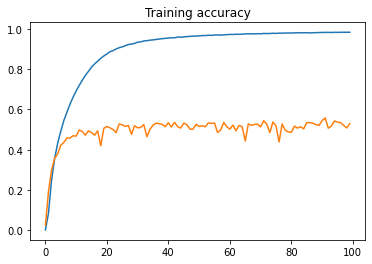

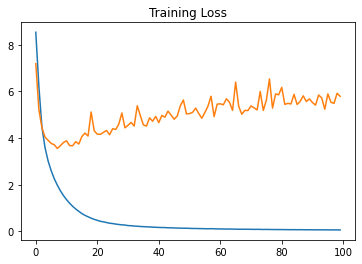

<Figure size 432x288 with 0 Axes>

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training Loss')
plt.figure()

In [19]:
gsedrfgdffg

NameError: name 'gsedrfgdffg' is not defined